# Reverse Engineering what the raw CAN packets mean
Going to leverage data from forscan to see what they mean

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import struct

In [2]:
fnameFORScan = "~/car/CANDumps/steeringTest_forscan_20180604_01.csv"
fnameSavvyCAN = "~/car/CANDumps/steeringTest_SavvyCAN_20180604_01.csv"

In [25]:
def readFORScan(fname):
    ''' 
    read a forscan output file to a dataframe
    # format is:
    | time[ms] | DATA1 | DATA2 | ... | DATA3 |
    |  <time>  | <val> | <val> | ... | <val> |
    '''
    
    data = pd.read_csv(fname,delimiter=";")
    #clean up column names
    newCols = {}
    for col in data.columns:
        newCols.update({col:col[:col.find("(")]})
    data = data.rename(index=bytes,columns=newCols)
    data = data[data.time>1000] # eliminate the first second of data, may have bad values
    data = data.reset_index(drop=True) # reset the index
    data = data.astype(np.float32)
    data["time"] = data.apply(lambda row: row["time"]/1e3,axis=1)
    return data

def readSavvyCAN(fname):
    '''
    read the savvycan dump to a dataframe
    '''
    dtype = {'Time Stamp':np.float32, 'ID':bytes, 'Extended':bool, 'Dir':str, 'Bus':int, 'LEN':int,
                            'D1':bytes, 'D2':bytes, 'D3':bytes,'D4':bytes, 'D5':bytes, 'D6':bytes, 'D7':bytes, 'D8':bytes}
    data = pd.read_csv(fname,index_col=False,dtype=dtype)# savvycan adds extra comma at end of line
    
    def convertToBytes(x):
        return bytes.fromhex(x)
    for col in ["ID","D1","D2","D3","D4","D5","D6","D7","D8"]:
        data[col] = data.apply(lambda row: convertToBytes(row[col]),axis=1)
        
    minVal = data["Time Stamp"].min()/1e6
    
    data["Time Stamp"] = data.apply(lambda row: row["Time Stamp"]/1e6-minVal,axis=1)

    return data

In [35]:
def convertTo_int8(data):
    '''
    Convert bytes into signed 8bit integer values
    '''
    length = len(data)
    
    return struct.unpack(length*"b",data)

def convertTo_uint8(data):
    '''
    Convert bytes into un-signed 8bit integer values
    '''
    length = len(data)
    return struct.unpack(length*"B",data)

def convertTo_int16(data):
    '''
    Convert 2 bytes into signed 16bit integer values
    '''
    return struct.unpack("h",data)[0]

In [36]:
dff = readFORScan(fnameFORScan)
dfs = readSavvyCAN(fnameSavvyCAN)

# Steering Angle
ID: \x738    Data: \x05 \x62 \x33 \x02

Convert by: struct.unpack("h",byte5 + byte6)[0]/30

Units: Degrees

min: -459.6000061035156 max: 473.5


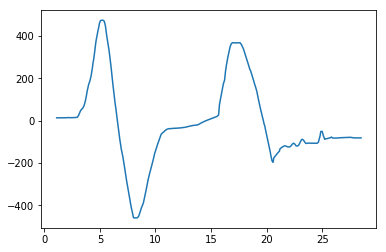

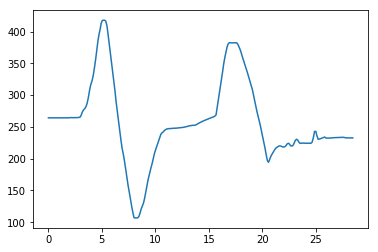

In [37]:
# filter by steering angle
angle = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x02")]
angle = angle.reset_index(drop=True)

print("min: {} max: {}".format(dff["STR_ANG"].min(),dff["STR_ANG"].max()))
plt.plot(dff["time"],dff["STR_ANG"])
plt.show()

d = angle.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)
d = d/30
plt.plot(angle["Time Stamp"],d)
plt.show()

# Steering Torque
ID: \x738    Data: \x04 \x62 \x33 \x0B

Convert by:(struct.unpack("B",byte5)[0]-127)/10

Units: N*m

min: -8.899999618530273 max: 10.100000381469727


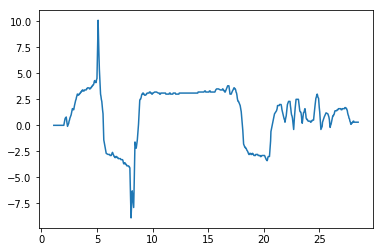

min: -8.9 max: 10.1


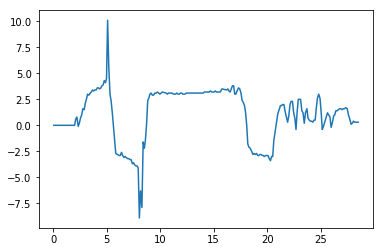

In [45]:
# filter by steering angle
torque = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x0b")]
torque = torque.reset_index(drop=True)

print("min: {} max: {}".format(dff["STR_TRQ_S_M"].min(),dff["STR_TRQ_S_M"].max()))
plt.plot(dff["time"],dff["STR_TRQ_S_M"])
plt.show()

t = torque.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)
t = (t-127)/10
print("min: {} max: {}".format(t.min(),t.max()))
plt.plot(torque["Time Stamp"],t)
plt.show()

# Steering Speed
## It looks like the numbers are likely too small for FORScan to output by default
ID: \x738    Data: \x04 \x62 \x33 \x01

Convert by:

Units: rev/min


In [60]:
print("Number of unique value in data from savvycan: {}".format(len(set(list(speed["D5"])))))

Number of unique value in data from savvycan: 69


min: 0.0 max: 0.0


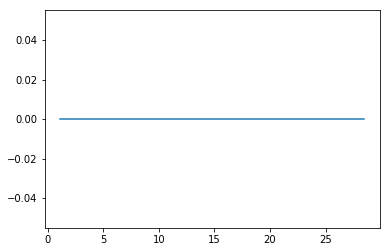

min: 0 max: 128


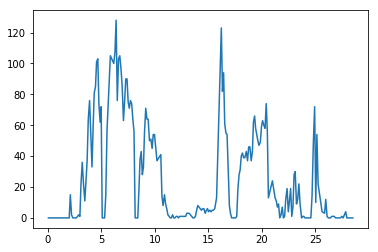

In [61]:
speed = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x01")]
speed = speed.reset_index(drop=True)

print("min: {} max: {}".format(dff["STR_ROT_SPD"].min(),dff["STR_ROT_SPD"].max()))
plt.plot(dff["time"],dff["STR_ROT_SPD"])
plt.show()

s = speed.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)
print("min: {} max: {}".format(s.min(),s.max()))
plt.plot(torque["Time Stamp"],s)
plt.show()

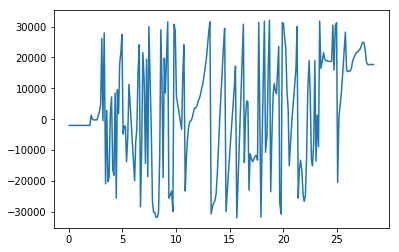

In [62]:

d = angle.apply(lambda row: convertTo_int16(row["D5"]+row["D6"]),axis=1)
plt.plot(angle["Time Stamp"],d)
plt.show()
# for sure not a short int

